# SHAP Feature Importance Explanation

This notebook provides a detailed analysis of feature importance using **SHAP (SHapley Additive exPlanations)**. We analyze the final calibrated model to understand which features most significantly influence the model's predictions.

### 1. Imports and Configuration

We start by importing the necessary libraries and setting up the project paths.

In [1]:
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import warnings

warnings.filterwarnings("ignore")

# -------------------------------------------------------------
# 1. Setup Paths
# -------------------------------------------------------------
project_root = Path.cwd().parent
MODELS_DIR = project_root / "models"
DATA_DIR = project_root / "data" / "processed" / "splits"
REPORTS_DIR = project_root / "reports"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

e:\AI Trading Signal Prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Load Test Data

We load the test dataset to use as a baseline for SHAP analysis, ensuring we exclude non-feature columns.

In [2]:
# -------------------------------------------------------------
# 2. Load Test Data (Test Split)
# -------------------------------------------------------------
test_path = DATA_DIR / "test.csv"
test_df = pd.read_csv(test_path)
print(f"Loaded test set: {test_df.shape}")

# Prepare X (excluding target/metadata columns)
exclude_cols = [
    "id", "status", "created_at", "target_type", 
    "hit_first", "coin", "TP1", "target_hit", "stop_hit"
]
feature_cols = [c for c in test_df.columns if c not in exclude_cols]
X_test = test_df[feature_cols].copy()

print(f"Selected {len(feature_cols)} features for SHAP analysis.")

Loaded test set: (3159, 13)
Selected 12 features for SHAP analysis.


### 3. Load the Final Model

We load the final calibrated model from the models directory. We also define the `CalibratedModelWrapper` to ensure the unpickling process works correctly.

In [3]:
# -------------------------------------------------------------
# 3. Load the Final Model
# -------------------------------------------------------------
# Inject wrapper because the model is wrapped in CalibratedModelWrapper
class CalibratedModelWrapper:
    def __init__(self, base_model, iso_model):
        self.base_model = base_model
        self.iso_model = iso_model
    def predict_proba(self, X):
        base = self.base_model.predict_proba(X)[:, 1]
        calibrated = self.iso_model.predict(base)
        return np.vstack([1 - calibrated, calibrated]).T
    def predict(self, X, thr=0.5):
        return (self.predict_proba(X)[:, 1] >= thr).astype(int)

import __main__
__main__.CalibratedModelWrapper = CalibratedModelWrapper

model_path = MODELS_DIR / "model_target_hit_final_calibrated.pkl"
model = joblib.load(model_path)
print(f"Loaded model from {model_path}")

Loaded model from e:\AI Trading Signal Prediction\AI-Trading-Signal-Prediction\models\model_target_hit_final_calibrated.pkl


### 4. Initialize SHAP Explainer

We determine the base model for SHAP analysis and initialize the appropriate explainer (TreeExplainer for tree-based models, or a generic Explainer as fallback).

In [4]:
# -------------------------------------------------------------
# 4. Define Base Model (for SHAP)
# -------------------------------------------------------------
# Extract the base model from the wrapper
use_model = model.base_model if hasattr(model, "base_model") else model

try:
    explainer = shap.TreeExplainer(use_model)
except Exception:
    explainer = shap.Explainer(use_model, X_test)
    print("Used generic SHAP explainer (fallback).")

### 5. Calculate SHAP Values

We take a sample of the test data and calculate the SHapley values to quantify each feature's contribution.

In [ ]:
# -------------------------------------------------------------
# 5. Calculate SHAP Values
# -------------------------------------------------------------
# Take a small sample if the data is large
sample = X_test.sample(min(1000, len(X_test)), random_state=42)
print(f"Using sample of {sample.shape[0]} rows for SHAP.")

# Compute SHAP values
shap_output = explainer(sample)   

# -------------------------------------------------------------
# Handle both modern and legacy SHAP formats
# -------------------------------------------------------------
if isinstance(shap_output, shap.Explanation):
    # Modern API (returns shap.Explanation)
    print(f"Detected SHAP Explanation object with shape: {shap_output.values.shape}")

    if shap_output.values.ndim == 3:
        # (n_samples, n_features, n_classes) → ناخد الـ class الإيجابي
        shap_values = shap_output.values[:, :, 1]
        final_shap_object = shap.Explanation(
            values=shap_output.values[:, :, 1],
            base_values=shap_output.base_values[:, 1] if shap_output.base_values.ndim == 2 else shap_output.base_values,
            data=sample,
            feature_names=feature_cols
        )
    else:
        shap_values = shap_output.values
        final_shap_object = shap_output

else:
    # Older API (raw numpy array or list)
    print(f"Detected legacy SHAP output type: {type(shap_output)}")
    if isinstance(shap_output, list):
        shap_values = shap_output[1]  # positive class
    else:
        shap_values = np.array(shap_output)
    final_shap_object = shap.Explanation(values=shap_values, data=sample, feature_names=feature_cols)

# Now shap_values is 2D (samples × features)
shap_values_df = pd.DataFrame(shap_values, columns=feature_cols)
print("✅ SHAP values ready:", shap_values_df.shape)

Using sample of 1000 rows for SHAP.
Detected SHAP Explanation object with shape: (1000, 12)
✅ SHAP values ready: (1000, 12)


### 6. Analyze Feature Importance

We calculate the mean absolute SHAP value for each feature to rank them by global importance.

In [6]:
# -------------------------------------------------------------
# 6. Calculate Feature Importance from SHAP Values
# -------------------------------------------------------------
shap_importance = (
    np.abs(shap_values_df).mean().sort_values(ascending=False)
)
top_features = shap_importance.head(10)
print("\nTop 10 Features by SHAP mean |importance|:")
print(top_features)


Top 10 Features by SHAP mean |importance|:
rsi_3d              0.420436
rsi_1d              0.389172
volume              0.296471
RSI                 0.252585
atr_1h              0.249335
close               0.221437
ratio_high_low      0.220258
ratio_close_high    0.173051
wick_ratio          0.170663
candle_body         0.131741
dtype: float32


### 7. Global Feature Importance Visualization

We plot a horizontal bar chart showing the top 10 most influential features and save the chart to the reports directory.

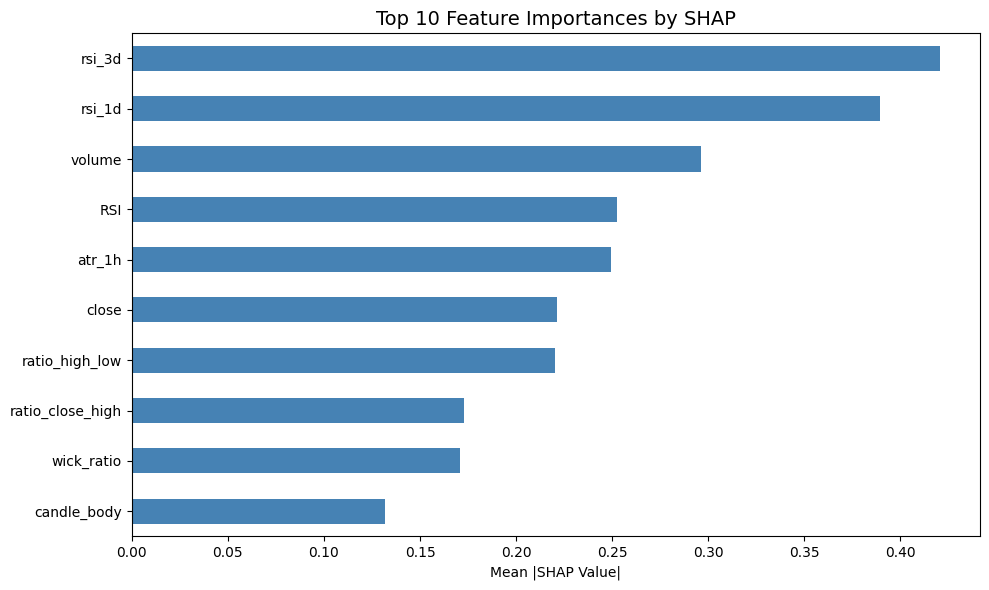

SHAP importance chart saved to: e:\AI Trading Signal Prediction\AI-Trading-Signal-Prediction\reports\shap_feature_importance.png


In [7]:
# -------------------------------------------------------------
# 7. Plot Bar Chart for Top 10 Features
# -------------------------------------------------------------
plt.figure(figsize=(10, 6))
top_features[::-1].plot(kind="barh", color="steelblue")
plt.title("Top 10 Feature Importances by SHAP", fontsize=14)
plt.xlabel("Mean |SHAP Value|")
plt.tight_layout()

save_path = REPORTS_DIR / "shap_feature_importance.png"
plt.savefig(save_path, dpi=300)
plt.show()
print(f"SHAP importance chart saved to: {save_path}")

### 8. Impact Direction Summary

The summary plot shows how each feature value impacts the model's output. Red points indicate high feature values, while blue points indicate low feature values. The horizontal position shows whether that value pushed the target probability up or down.

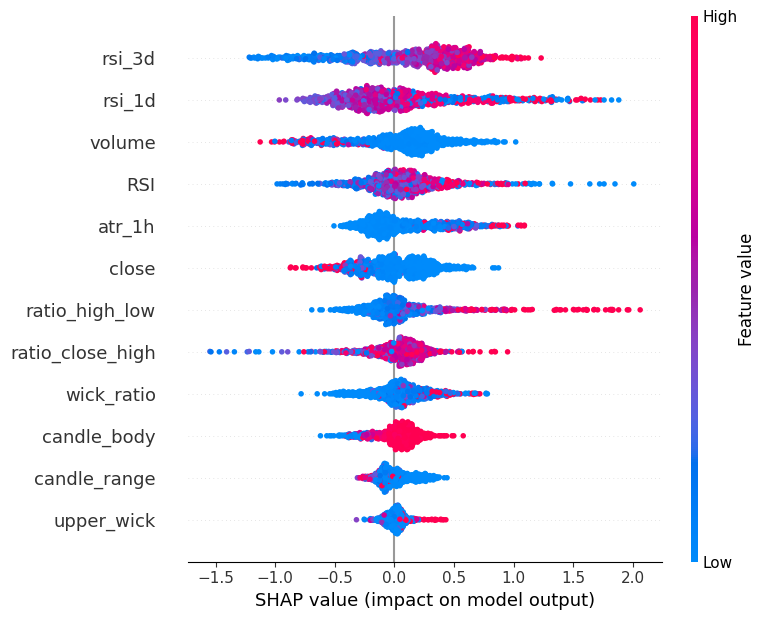

<Figure size 640x480 with 0 Axes>

SHAP importance chart saved to: e:\AI Trading Signal Prediction\AI-Trading-Signal-Prediction\reports\shap_summary_beeswarm.png


In [9]:
# -------------------------------------------------------------
# 8. Global Summary Plot
# -------------------------------------------------------------
try:
    shap.summary_plot(shap_values, features=sample, feature_names=feature_cols)
    save_path = REPORTS_DIR / "shap_summary_beeswarm.png"
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"SHAP importance chart saved to: {save_path}")
except Exception as e:
    print(f"Couldn't render SHAP summary plot → {e}")
